Principalmente buscamos resolver el problema de la deteccion de si una planta de tomate esta sana o enferma, para eso hemos planteado usar redes neuronales convolucionales ya que tiene una alta capacidad predictiva para problemas que requieren la clasificacion de imagenes debido a la naturaleza de sus capas convolucionales.

## Importando librerías

**Estas bibliotecas son esenciales para el desarrollo y entrenamiento de modelos de aprendizaje automático y redes neuronales. TensorFlow es una de las bibliotecas más ampliamente utilizadas para crear, entrenar y desplegar modelos de aprendizaje profundo. Proporciona un entorno flexible y eficiente para definir y ejecutar operaciones matemáticas en gráficos computacionales, lo que es fundamental para la construcción de redes neuronales.**

In [1]:
import tensorflow as tf
import pandas as pd 
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras import models, layers
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Concatenate, Add, Reshape, Dot
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, array_to_img, img_to_array
from keras.applications.vgg19 import VGG19
from tensorflow.keras.models import load_model

In [2]:
from PIL import Image

# Ruta de la imagen
image_path = '/kaggle/input/tomatecorregido/Tomatos/TEST/Healthy/0031da2a-8edd-468f-a8b1-106657717a32___RS_HL 0105.JPG'

# Abrir la imagen con PIL
image = Image.open(image_path)

# Obtener el tamaño de píxeles
width, height = image.size

# Imprimir el tamaño de píxeles
print("Ancho:", width)
print("Alto:", height)

Ancho: 256
Alto: 256


## Creación del modelo convolucional

****Una CNN es un tipo de red neuronal especialmente diseñada para procesar datos con una estructura de cuadrícula, como imágenes. La arquitectura definida aquí consta de varias capas convolucionales intercaladas con capas de normalización y agrupación (pooling), seguidas de capas completamente conectadas.**

**En cada bloque de capas convolucionales, se realizan operaciones de convolución y activación ReLU para extraer características de la imagen. La capa de normalización BatchNormalization ayuda a estabilizar y acelerar el entrenamiento de la red, y la capa de agrupación MaxPooling reduce el tamaño de las representaciones para mantener un procesamiento eficiente. Los bloques convolucionales se escalan gradualmente, aumentando el número de filtros para capturar características más abstractas.
**
Después de las capas convolucionales, se añade una capa Flatten para aplanar los datos y luego se conecta a capas completamente conectadas. Una capa Dense con 512 unidades y activación ReLU ayuda a aprender representaciones más abstractas y complejas de los datos. Se aplica un Dropout del 20% para evitar el sobreajuste durante el entrenamiento. Finalmente, hay una capa Dense con una sola unidad y activación sigmoide para la clasificación binaria, donde se intenta distinguir entre dos clases, en este caso "Tomate sano" y "Tomate enfermo".**

In [3]:
model = models.Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Conv2D(512, (3,3), activation='relu',  padding='same'))
model.add(Conv2D(512, (3,3), activation='relu',  padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 123, 123, 128)     7

## Data augmentation

La instancia de ImageDataGenerator de TensorFlow se utiliza para aplicar diversas transformaciones a las imágenes durante el entrenamiento. Las transformaciones incluyen rotación aleatoria, desplazamiento horizontal y vertical, corte (shearing), zoom y volteo horizontal. Cada vez que una imagen se pasa a través del generador durante el entrenamiento, se aplica una combinación aleatoria de estas transformaciones, lo que resulta en imágenes ligeramente diferentes.

In [4]:
##APLICAMOS LA TECNICA DE AUMENTADO DE DATOS A CADA IMAGEN
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

train_path="/kaggle/input/tomateus/tomato_dataset/train"
valid_path="/kaggle/input/tomateus/tomato_dataset/valid"
test_path="/kaggle/input/tomateus/tomato_dataset/test"

## Reescalar los datos

In [5]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
##Hacemos el data aumentation para imagenes de la carpeta TRAIN
train_set = train_datagen.flow_from_directory(train_path,
                                 target_size=(256,256),
                                 batch_size=32, ##Tamaño de lote de cada iteracion
                                 class_mode='binary', ##Clasificacion de tipo binaria
                                 shuffle=True
                                 )
##Hacemos el data aumentation para imagenes de la carpeta VALIDATION
valid_set = valid_datagen.flow_from_directory(valid_path,
                                 target_size=(256,256),
                                 batch_size=32, ##Tamaño de lote de cada iteracion
                                 class_mode='binary', ##Clasificacion de tipo binaria
                                shuffle=True
                                 )
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(256,256),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                           shuffle=True)

Found 2400 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


## Callbacks

Este callback ajusta automáticamente la tasa de aprendizaje del optimizador en función de la disminución de la pérdida durante el entrenamiento. Si la pérdida no mejora después de un número específico de épocas (patience), la tasa de aprendizaje se reduce multiplicándola por un factor (factor). Esto permite un ajuste más preciso del proceso de entrenamiento, aumentando gradualmente la tasa de aprendizaje si el modelo se encuentra en una región de pérdida alta y disminuyéndola cuando se alcanza una meseta en el proceso de optimización. El valor mínimo de la tasa de aprendizaje se establece en 0.00001 para evitar que disminuya indefinidamente.

In [7]:
##CREAMOS UN DIRECTORIO DE SALIDA QUE GUARDE EL MODELO(LOS PESOS) QUE OBTENGA MEJOR RESULTADO AL ENTRENAR EL MODELO

from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='loss'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.75
                                            , min_lr=0.00001)

## Entrenando el modelo

In [8]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=["accuracy"]
              
)

epochs = 100

hist = model.fit(train_set,
                                    steps_per_epoch=len(train_set),  
                                    validation_data=valid_set,
                                epochs=100,
                                callbacks=[learning_rate_reduction],
                                validation_steps=len(valid_set),
                                verbose=1,
                            )

Epoch 1/100
75/75 [==============================] - 68s 736ms/step - loss: 11.2207 - accuracy: 0.6692 - val_loss: 0.9649 - val_accuracy: 0.2917
Epoch 2/100
75/75 [==============================] - 45s 599ms/step - loss: 1.1073 - accuracy: 0.7796 - val_loss: 161.7643 - val_accuracy: 0.4992
Epoch 3/100
75/75 [==============================] - 46s 607ms/step - loss: 0.5665 - accuracy: 0.8467 - val_loss: 59.5543 - val_accuracy: 0.5825
Epoch 4/100
75/75 [==============================] - 45s 596ms/step - loss: 0.6415 - accuracy: 0.8788 - val_loss: 91.0142 - val_accuracy: 0.5417
Epoch 5/100
75/75 [==============================] - 47s 620ms/step - loss: 0.6125 - accuracy: 0.8692 - val_loss: 66.3635 - val_accuracy: 0.5267

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Epoch 6/100
75/75 [==============================] - 45s 599ms/step - loss: 0.1930 - accuracy: 0.9304 - val_loss: 33.5213 - val_accuracy: 0.5408
Epoch 7/100
75/75 [=============================

## Resultados

In [9]:
import matplotlib.pyplot as plt
scores2 = model.evaluate(test_set)
scores2

38/38 [==============================] - 8s 217ms/step - loss: 2.6707 - accuracy: 0.9125


[2.670699119567871, 0.9125000238418579]

In [10]:
scores1 = model.evaluate(valid_set)
scores1

38/38 [==============================] - 4s 101ms/step - loss: 1.6980 - accuracy: 0.9225


[1.698025107383728, 0.9225000143051147]

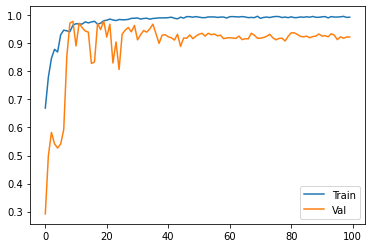

In [11]:
##MOSTRAMOS LA VARIACION ENTRE EL ACURRACY DE ENTRENAMIENTO Y VALIDACION
plt.plot(hist.history['accuracy'], label = 'Train')
plt.plot(hist.history['val_accuracy'], label = 'Val')
plt.legend()
plt.show()

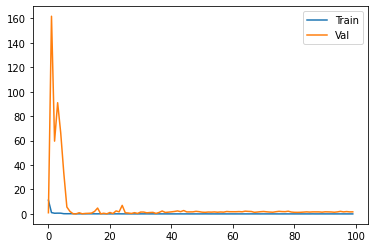

In [12]:
##MOSTRAMOS LA VARIACION ENTRE EL ACURRACY DE ENTRENAMIENTO Y VALIDACION
plt.plot(hist.history['loss'], label = 'Train')
plt.plot(hist.history['val_loss'], label = 'Val')
plt.legend()
plt.show()

In [13]:
class_names = list(train_set.class_indices.keys())
class_names

['Tomato_healthy', 'Tomato_unhealthy']

In [14]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    confidence = round(100 * predictions[0][0], 2)

    if predictions[0][0] < 0.5:
        predicted_class = class_names[0]
        confidence = round(100 - confidence, 2)
    else:
        predicted_class = class_names[1]
    
    return predicted_class, confidence

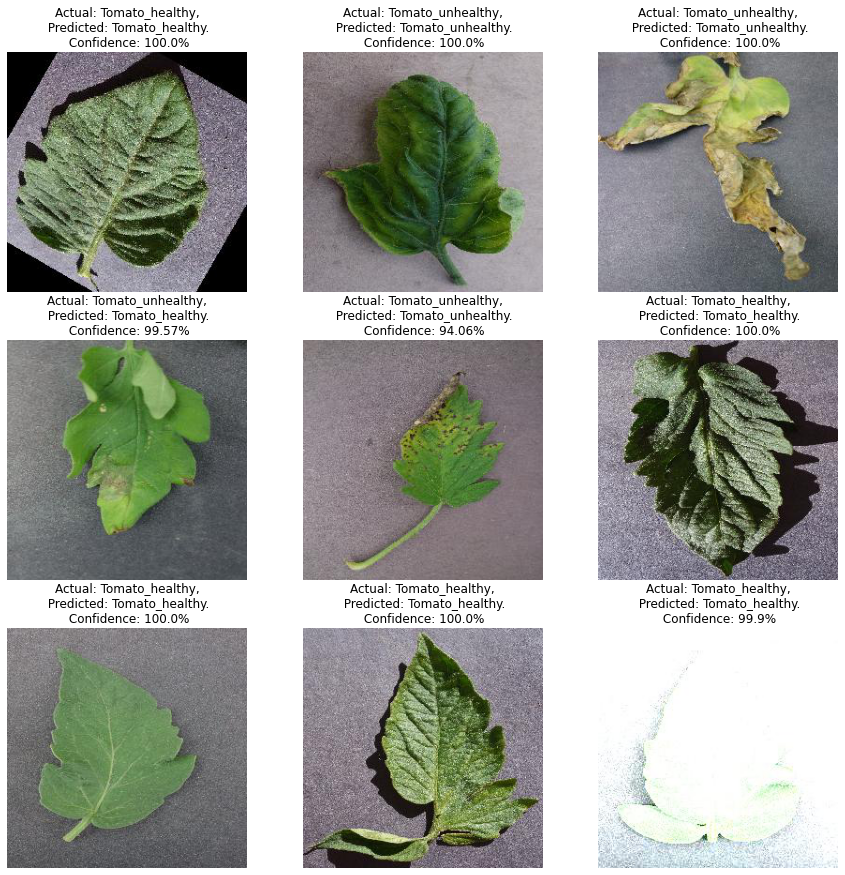

In [15]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_set:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [16]:
valid_set1 = valid_datagen.flow_from_directory(valid_path,
                                            target_size = (256,256),
                                            batch_size = 64,
                                            class_mode = 'binary',
                                             shuffle=False)

Found 1200 images belonging to 2 classes.


In [17]:
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
# Obtener las predicciones
Y_pred = model.predict(valid_set1)
y_pred = (Y_pred > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias (0 o 1)
y_true = valid_set1.classes
class_names = list(valid_set1.class_indices.keys())

# Calcular el informe de clasificación
report = classification_report(y_true, y_pred, target_names=class_names)

print(report)

                  precision    recall  f1-score   support

  Tomato_healthy       0.87      1.00      0.93       600
Tomato_unhealthy       1.00      0.84      0.92       600

        accuracy                           0.92      1200
       macro avg       0.93      0.92      0.92      1200
    weighted avg       0.93      0.92      0.92      1200



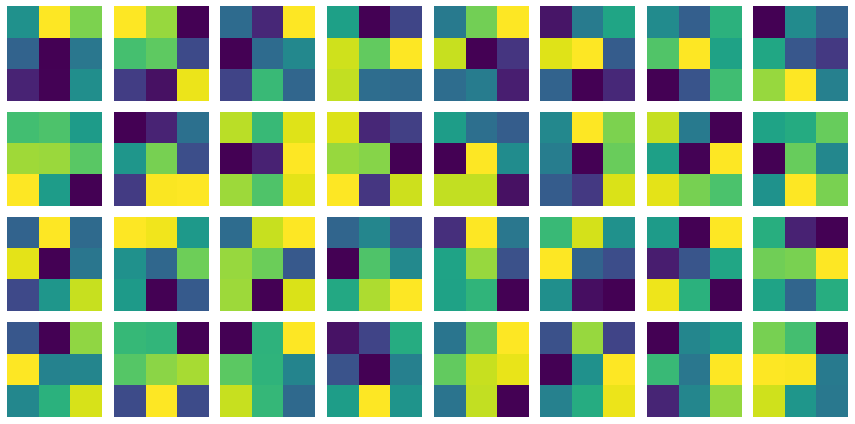

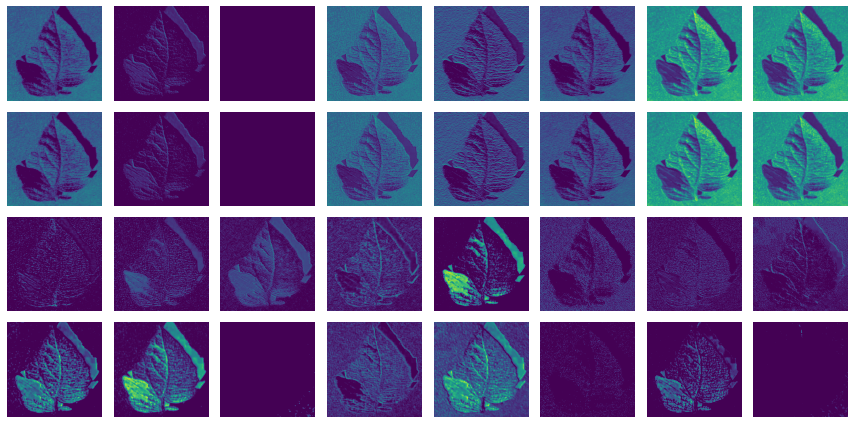

In [18]:
##OBSERVAR LOS PRIMEROS 32 KERNEL Y SU EFECTO EN LAS IMAGENES DE NUESTRA CAPA CONVOLUCIONAL
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

# Obtener los pesos de la primera capa convolucional
weights = model.layers[0].get_weights()[0]

# Visualizar los filtros
fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(weights[:, :, 0, i*8+j], cmap='viridis')  # Se asume que los filtros son de tamaño 3D (alto x ancho x canales)
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

# Cargar y preprocesar una imagen de muestra
image_path = "/kaggle/input/tomatecorregido/Tomatos/TEST/Healthy/0031da2a-8edd-468f-a8b1-106657717a32___RS_HL 0105.JPG"  # Ruta de la imagen que deseas procesar

def preprocess_image(image_path):
    image = load_img(image_path, target_size=(256, 256))
    image = np.array(image) / 255.0  # Normalizar la imagen
    image = np.expand_dims(image, axis=0)
    return image

image = preprocess_image(image_path)

# Obtener las feature maps
layer_outputs = [layer.output for layer in model.layers[:4]]  # Obtener las salidas de las capas convolucionales
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
feature_maps = activation_model.predict(image)

# Visualizar las feature maps
fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[i][0, :, :, j], cmap='viridis')  # Se asume que las feature maps son de tamaño 3D (alto x ancho x canales)
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [19]:
##OBSERVAMOS LOS KERNELS DE MANERA MATRICIAL
# Obtener los pesos de la primera capa convolucional
weights = model.layers[0].get_weights()[0]

# Obtener las dimensiones de los filtros
num_filters = weights.shape[3]
filter_size = weights.shape[0]

# Mostrar las matrices de los kernels
for i in range(num_filters):
    print("Kernel {}:".format(i+1))
    print(weights[:, :, 0, i])
    print()

Kernel 1:
[[ 7.05699931e-05  1.16540477e-01  7.00586811e-02]
 [-4.40487787e-02 -1.18562855e-01 -2.53058113e-02]
 [-9.54212621e-02 -1.17206544e-01 -2.58479454e-03]]

Kernel 2:
[[ 0.13251601  0.09862992 -0.08912492]
 [ 0.06736309  0.07711534 -0.03907019]
 [-0.04923226 -0.07927965  0.12603103]]

Kernel 3:
[[-0.09428466 -0.14330077  0.03848263]
 [-0.1657183  -0.0944287  -0.07015943]
 [-0.12379297 -0.02769889 -0.09848256]]

Kernel 4:
[[ 0.03208873 -0.09491188 -0.04787622]
 [ 0.11190824  0.07442032  0.12825556]
 [ 0.1077835  -0.0152304  -0.01801473]]

Kernel 5:
[[-0.01137682  0.06961013  0.11504292]
 [ 0.09662344 -0.09994092 -0.0671422 ]
 [-0.02288535 -0.0100254  -0.08202841]]

Kernel 6:
[[-0.11858922 -0.03489828  0.00527989]
 [ 0.09031816  0.10190514 -0.0636657 ]
 [-0.05782594 -0.13210735 -0.10508054]]

Kernel 7:
[[ 0.02423685 -0.01406309  0.05886452]
 [ 0.07656411  0.13436879  0.0447182 ]
 [-0.07795206 -0.02276298  0.06944025]]

Kernel 8:
[[-0.0818364   0.02100968 -0.01497686]
 [ 0.0452343

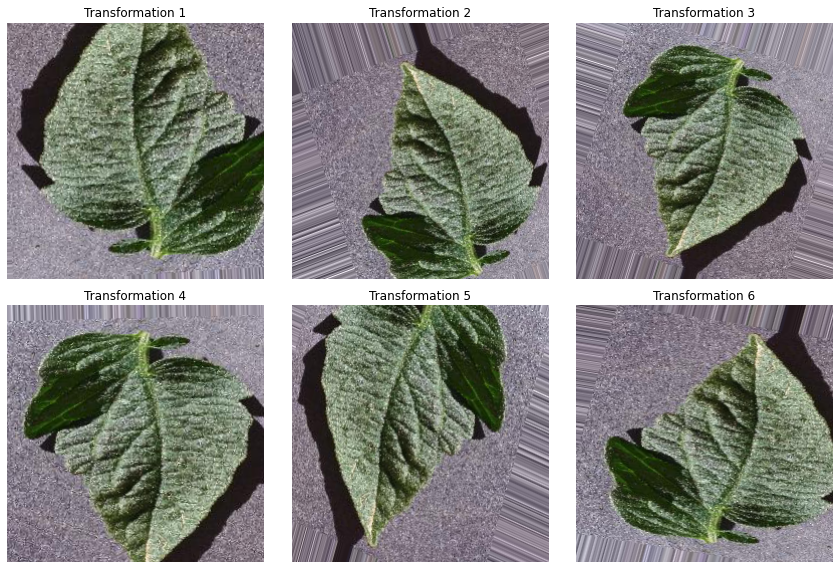

In [20]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorio donde se encuentran las imágenes originales
original_images_dir = '/kaggle/input/tomatecorregido/Tomatos/TEST/Healthy'

# Cargar la imagen original
original_image_path = '/kaggle/input/tomatecorregido/Tomatos/TEST/Healthy/0031da2a-8edd-468f-a8b1-106657717a32___RS_HL 0105.JPG'
original_image = plt.imread(original_image_path)

# Normalizar la escala de los píxeles
original_image = original_image / 255.0

# Definir las transformaciones de aumento de datos
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Mostrar las imágenes con las transformaciones
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Mostrar la imagen original
ax[0, 0].imshow(original_image)
ax[0, 0].set_title('Original')
ax[0, 0].axis('off')

# Generar y mostrar las imágenes aumentadas
i = 0
for batch in data_augmentation.flow(original_image.reshape(1, *original_image.shape), batch_size=1):
    image = batch[0]
    row = i // 3
    col = i % 3
    ax[row, col].imshow(image)
    ax[row, col].set_title(f'Transformation {i+1}')
    ax[row, col].axis('off')
    i += 1
    if i >= 6:
        break

plt.tight_layout()
plt.show()

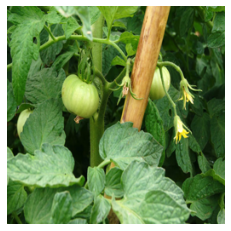

array([1.], dtype=float32)

In [21]:
###PROBAR CON DATOS DE INTERNET
import urllib.request
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# Definir la URL de la imagen
image_url = 'https://www.elhuertourbano.net/wp-content/uploads/plantas-y-flores-de-tomatera-1.jpg'

# Descargar la imagen desde la URL
urllib.request.urlretrieve(image_url, 'image.jpg')

# Cargar la imagen descargada usando PIL
image = Image.open('image.jpg')

# Convertir la imagen a modo RGB si tiene un canal adicional (alfa)
if image.mode == 'RGBA':
    image = image.convert('RGB')

# Redimensionar la imagen a las dimensiones requeridas por tu modelo
# Puedes ajustar las dimensiones según las necesidades de tu modelo
image = image.resize((256, 256))

# Convertir la imagen a un arreglo NumPy
image_array = np.array(image)

# Preprocesar la imagen según los requisitos de tu modelo
# Por ejemplo, normalizar los valores de píxeles
preprocessed_image = image_array / 255.0

# Mostrar la imagen
plt.imshow(preprocessed_image)
plt.axis('off')
plt.show()

# Hacer la predicción con tu modelo
prediction = model.predict(np.expand_dims(preprocessed_image, axis=0))
prediction[0]

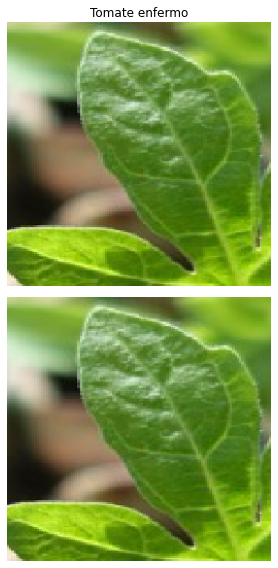

In [22]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def preprocess_image1(image_path3):
    img = load_img(image_path3, target_size=(256, 256))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_image(image_path3):
    img = preprocess_image1(image_path3)
    prediction = model.predict(img)
    if prediction[0][0] < 0.5:
        prediction_text = "Tomate sano"
    else:
        prediction_text = "Tomate enfermo"
    return prediction_text, img[0]

# Ruta de la imagen a predecir
image_path3 = '/kaggle/input/dadaaff/WhatsApp Image 2023-06-30 at 1.07.54 PM.jpeg'

# Realizar la predicción
prediction_text, predicted_image = predict_image(image_path3)

# Mostrar el resultado
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# Mostrar la imagen con el texto de predicción
ax1.imshow(predicted_image)
ax1.set_title(prediction_text)
ax1.axis('off')

# Mostrar solo la imagen
ax2.imshow(predicted_image)
ax2.axis('off')

plt.tight_layout()
plt.show()

In [23]:
valid_set1 = valid_datagen.flow_from_directory(valid_path,
                                            target_size = (256,256),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                             shuffle=False)

Found 1200 images belonging to 2 classes.


In [24]:
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
# Obtener las predicciones
Y_pred = model.predict(valid_set1)
y_pred = (Y_pred > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias (0 o 1)
y_true = valid_set1.classes
class_names = list(valid_set1.class_indices.keys())

# Calcular el informe de clasificación
report = classification_report(y_true, y_pred, target_names=class_names)

print(report)

                  precision    recall  f1-score   support

  Tomato_healthy       0.87      1.00      0.93       600
Tomato_unhealthy       1.00      0.84      0.92       600

        accuracy                           0.92      1200
       macro avg       0.93      0.92      0.92      1200
    weighted avg       0.93      0.92      0.92      1200



In [25]:
model.save('model.h5')